In [2]:
from __future__ import division

import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from itertools import product
from datetime import *
from dateutil.relativedelta import *

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Для выполнения этого задания нам понадобятся данные о среднемесячных уровнях заработной платы в России

In [3]:
#Reading data
wage = pd.read_csv('WAG_C_M.csv', sep=';', index_col='month', parse_dates=True, dayfirst=True)
wage.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 284 entries, 1993-01-01 to 2016-08-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   WAG_C_M  284 non-null    float64
dtypes: float64(1)
memory usage: 4.4 KB


In [4]:
wage.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


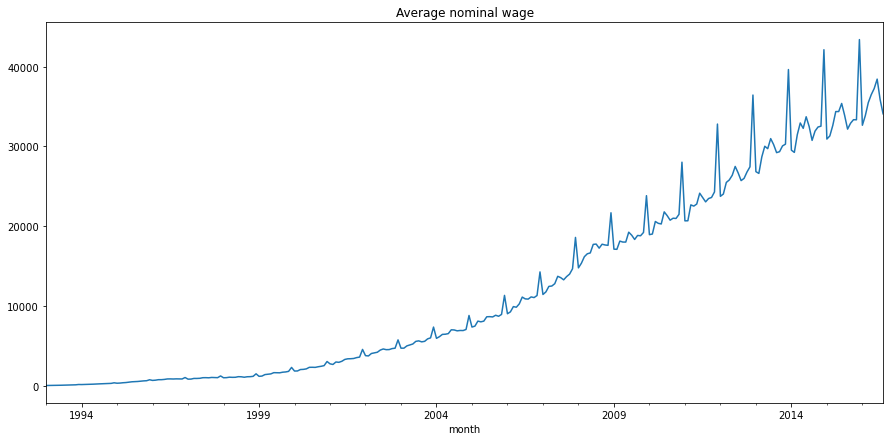

In [5]:
_ = plt.figure(figsize=(15,7))
_ = wage.WAG_C_M.plot()
_ = plt.title('Average nominal wage')

Проверка стационарности и STL-декомпозиция ряда:

Augmented Dickey-Fuller unit root test p=0.991850


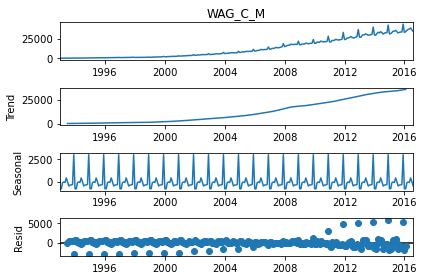

In [6]:
_ = sm.tsa.seasonal_decompose(wage.WAG_C_M).plot()
print('Augmented Dickey-Fuller unit root test p=%f' % sm.tsa.stattools.adfuller(wage.WAG_C_M)[1])

Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Optimal parameter of the Box-Cox power transformation: 0.263202
Augmented Dickey-Fuller unit root test p=0.696899


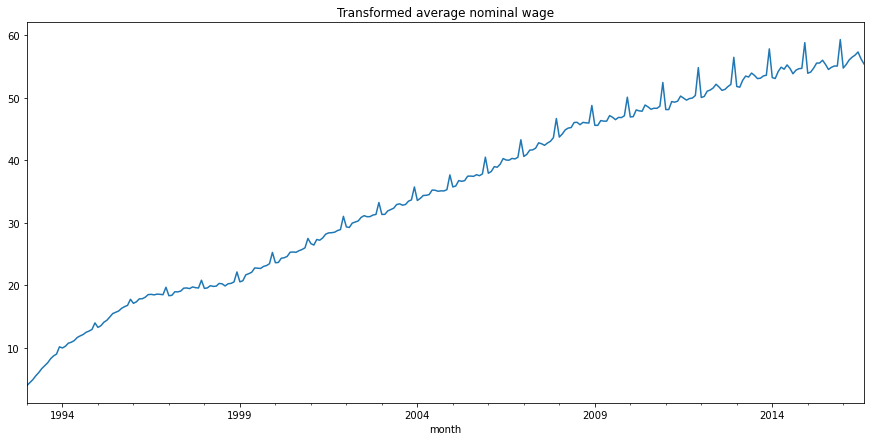

In [7]:
wage['WAG_C_M_box'], lmbda = stats.boxcox(wage.WAG_C_M)

_ = plt.figure(figsize=(15,7))
_ = wage.WAG_C_M_box.plot()
_ = plt.title(u'Transformed average nominal wage')

print('Optimal parameter of the Box-Cox power transformation: %f' % lmbda)
print('Augmented Dickey-Fuller unit root test p=%f' % sm.tsa.stattools.adfuller(wage.WAG_C_M_box)[1])

Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Augmented Dickey-Fuller unit root test p=0.014697


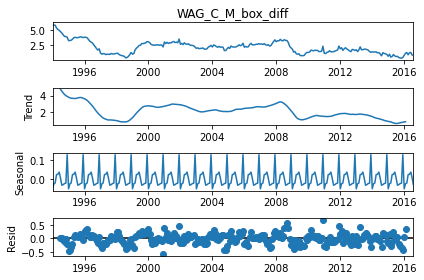

In [8]:
wage['WAG_C_M_box_diff'] = wage.WAG_C_M_box - wage.WAG_C_M_box.shift(12)
_ = sm.tsa.seasonal_decompose(wage.WAG_C_M_box_diff.dropna()).plot()
print('Augmented Dickey-Fuller unit root test p=%f' % sm.tsa.stattools.adfuller(wage.WAG_C_M_box_diff.dropna())[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, НО полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Augmented Dickey-Fuller unit root test p=0.000000


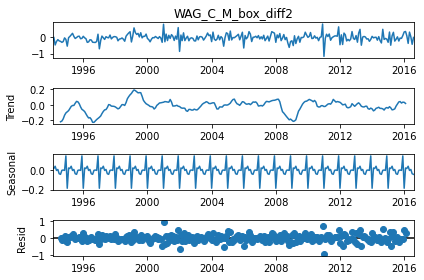

In [9]:
wage['WAG_C_M_box_diff2'] = wage.WAG_C_M_box_diff - wage.WAG_C_M_box_diff.shift(1)
_ = sm.tsa.seasonal_decompose(wage.WAG_C_M_box_diff2.dropna()).plot()
print('Augmented Dickey-Fuller unit root test p=%f' % sm.tsa.stattools.adfuller(wage.WAG_C_M_box_diff2.dropna())[1])

Гипотеза нестационарности отвергается с ещё большим уровнем значимости, и визуально ряд выглядит лучше — тренда больше нет.

Подбор модели

Посмотрим на ACF и PACF полученного ряда:

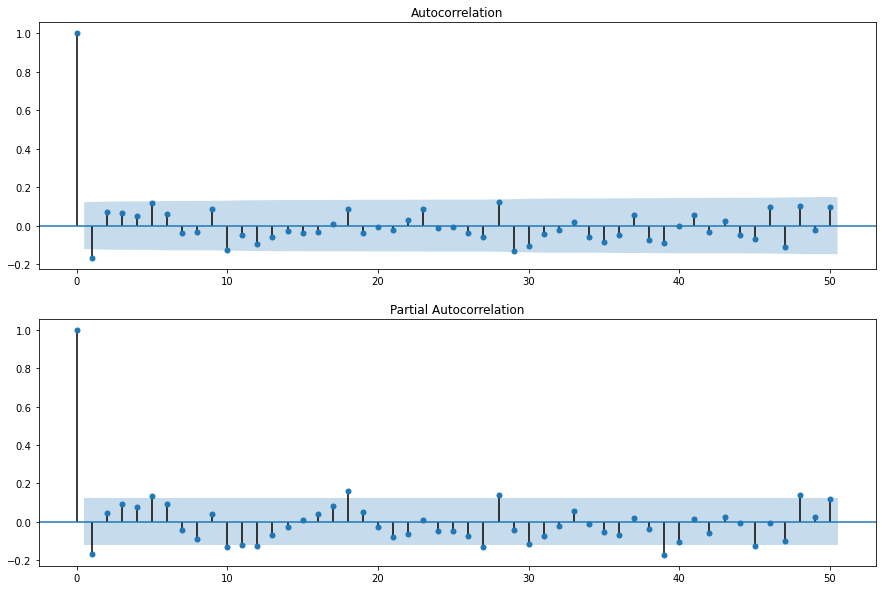

In [10]:
plt.figure(figsize=(15,10))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage.WAG_C_M_box_diff2.dropna()[12:].squeeze(), lags=50, ax=ax);

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage.WAG_C_M_box_diff2.dropna()[12:].squeeze(), lags=50, ax=ax);

Начальные приближения: Q=0, q=1, P=1, p=1

In [11]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [12]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
parameters_list
len(parameters_list)

[(0, 0, 0, 0),
 (0, 0, 1, 0),
 (0, 1, 0, 0),
 (0, 1, 1, 0),
 (1, 0, 0, 0),
 (1, 0, 1, 0),
 (1, 1, 0, 0),
 (1, 1, 1, 0)]

8

In [13]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wage.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 1.46 s


In [14]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
5  (1, 0, 1, 0)  0.340521
3  (0, 1, 1, 0)  1.170768
7  (1, 1, 1, 0)  2.021911
4  (1, 0, 0, 0)  2.625709
2  (0, 1, 0, 0)  3.369832


Лучшая модель

In [15]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Tue, 05 Jan 2021   AIC                              0.341
Time:                                    18:08:41   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Её остатки:

Критерий Стьюдента: p=0.090795
Критерий Дики-Фуллера: p=0.000003


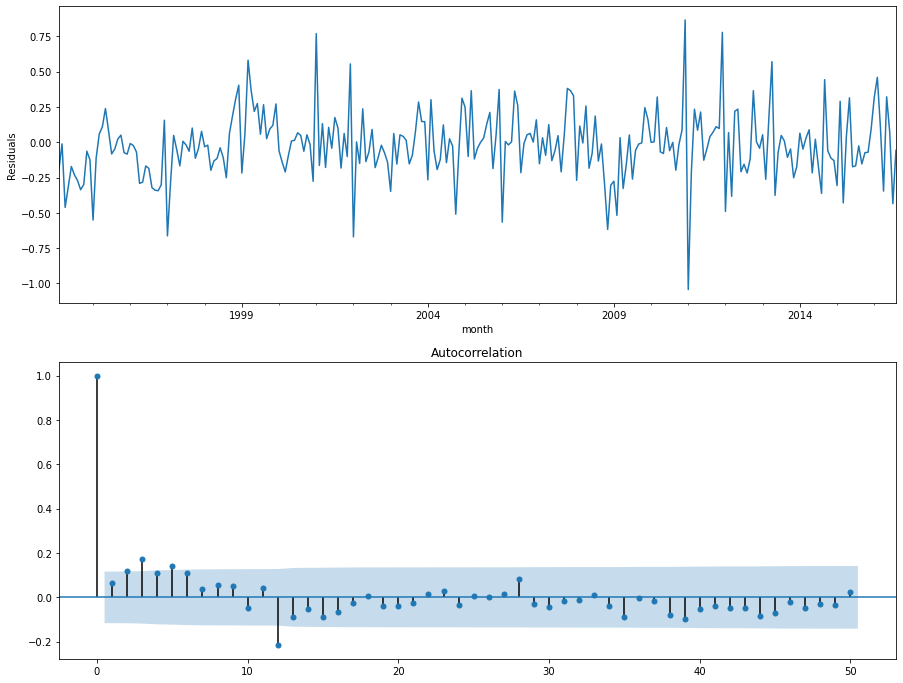

In [16]:
_ = plt.figure(figsize=(15,12))
_ = plt.subplot(211)
_ = best_model.resid[13:].plot()
_ = plt.ylabel(u'Residuals')

_ = ax = plt.subplot(212)
_ = sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=50, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента), стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

In [17]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

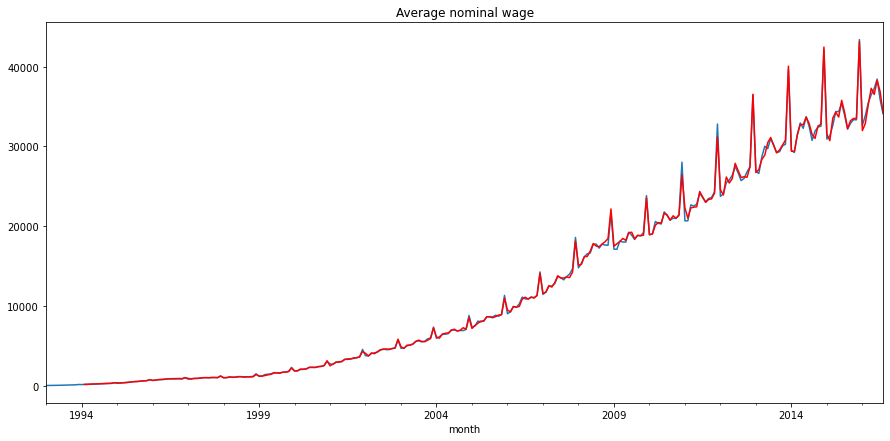

In [18]:
wage['model'] = invboxcox(best_model.fittedvalues, lmbda)

_ = plt.figure(figsize=(15,7))
_ = wage.WAG_C_M.plot()
_ = wage.model[13:].plot(color='r')
_ = plt.title('Average nominal wage')

# Прогноз

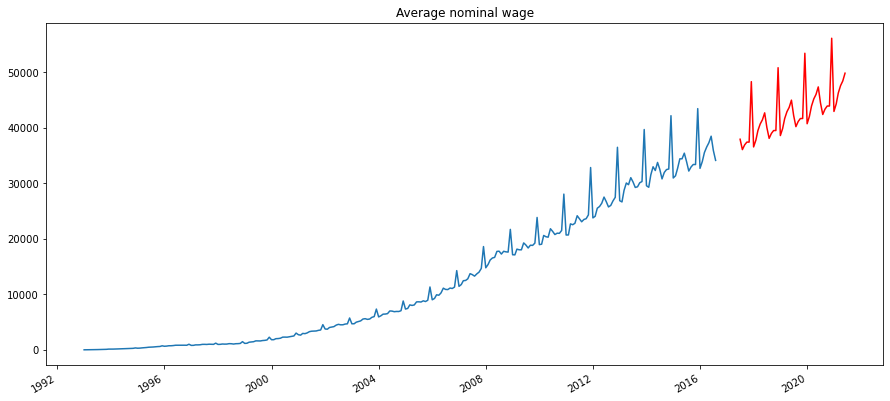

In [24]:
wage2 = wage[['WAG_C_M']]
date_list = [datetime.strptime("2017-07-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,48)]
future = pd.DataFrame(index=date_list, columns=wage2.columns)
wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(best_model.predict(start=294, end=450), lmbda)

_ = plt.figure(figsize=(15,7))
_ = wage2.WAG_C_M.plot()
_ = wage2.forecast.plot(color='r')
_ = plt.title('Average nominal wage')